6/15/20
Hi! This is an application of my learning through the Machine Learning Intro and Intermediate Courses I took on Kaggle.

This model fell within the 67th percentile of all competitors who entered the Titanic: Machine Learning from Disaster Kaggle competition- Which isn't amazing, but pretty good for my first attempt at applying models and cleaning data!

Our central goal/question for this project is: From a training set of samples listing passengers who survived or did not survive the Titanic, can our model determine whether passengers from a test dataset also survived?

In [37]:
#Data Analysis
import pandas as pd

#Data modeling/ML
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#Data visualization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re as re

Here, I'm importing the data used to train and test our model. They're both downloaded from the Kaggle Competition website. Let's look at the column names on the dataset below- when doing this, we should take into account a couple things; is the data numerical or categorical? Are there numerous missing values? Are there errors/typos? 
 - PassengerId (numerical) : Numbers each passenger on the Titanic.
 - Survived (numerical) : Gives a 1 if the passenger survived, and a 0 if the passenger didn't.
 - Pclass (numerical) : Represents socioeconomic status- a 1 for Upper class, 2 for middle, and 3 for lower.
 - Name (categorical) : The name of the passenger (including their title).
 - Sex (categorical) : The gender of the passenger.
 - Age (numerical) : The age of the passenger.
 - SibSp (numerical) : The number of siblings/spouses the passenger has aboard.
 - Parch (numerical) : The number of parents/children the passenger has aboard.
 - Ticket (both) : The passenger's ticket number.
 - Fare (numerical) : The passenger's fare for Titanic.
 - Cabin (both) : The passenger's cabin number on the Titanic. The values in this column are mostly missing.
 - Embarked (categorical) : Where the passenger embarked from.

In [38]:
#import training and test data
train_data = pd.read_csv("/Users/hannahjiang/Desktop/titanic/titanictrain.csv")
test_data = pd.read_csv("/Users/hannahjiang/Desktop/titanic/titanictest.csv")
total_data = [train_data, test_data]
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now, by looking at the data, we should decide which columns will be the greatest factor in a passenger's survival. First, Let's look at how a passenger's socioeconomic status affected their chances of survival.

The table below shows the three classes and the probability of survival within each class. As we moved from a lower to upper socioeconomic class, the chances of survival increased for each class. This represents a correlation between survival and higher socioeconomic classes, so we'll consider this in our model.

In [39]:
#Let's check if some of our features correlate to survival,
#starting with the ones we're unsure about, like class, fare, and sex
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


What about a passenger's gender? Below, there's a signifigantly higher chance of females surviving, so we'll include this in our model, too.

In [40]:
#There is high correlation between being a female and surviving
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


As I was going through the data, I decided that a passenger's loved ones would have an effect on the passenger's survival. While this was proven to be somewhat true in the tables below, I decided that rather than looking at siblings, parents, and spouses seperately, it would be easier to find a correlation if we combined them into one group- family size.

In [41]:
#With the Patch and sibling data, it's hard to tell, so we can pair these together with family size - becuase
#being in a family will lower chances of survival vs. when you're on your own
train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [42]:
train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


As can be seen below, passengers with a family size of 4 (including themselves) correlated with a higher chance of survival.

In [43]:
for data in total_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
print (train_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


I also decided that it would be easier for a model to determine the survival of a passenger by whether they were alone or not- in the table below, 1 represents someone who was alone, while 0 represents someone who wasn't.

In [44]:
#Make a feature called IsAlone
for data in total_data:
    data["IsAlone"] = 0
    data.loc[data["FamilySize"] == 1, "IsAlone"] = 1

train_data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


A passenger's paid fare can also determine their survival; as seen below, those with a higher fare were more likely to survive, perhaps due to their location on the boat at the time of the crash.

In [45]:
#For the Fare, let's categorize certain groups (since they're all varied). We can see that a higher fare meant a higher chance of survival

print (train_data[['Fare', 'Survived']].groupby(pd.qcut(train_data['Fare'], 4), as_index=False).mean())

        Fare  Survived
0   7.034172  0.197309
1  10.386050  0.303571
2  23.028677  0.454955
3  88.677872  0.581081


Age can also have an effect on a passenger's survival. As can be seen below, a higher percentage of passengers close to the age of 0 and very few passangers above the age of 60 survived. We'll consider age in our model, too.

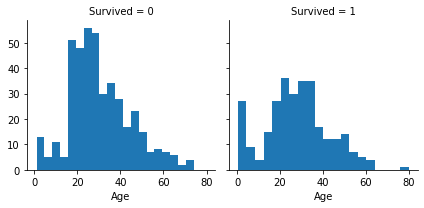

In [46]:
#We can see age correlation to survival through graphs - as we can see, being younger (closer to 0)
#means a higher chance of survival
age_correlation = sns.FacetGrid(train_data, col='Survived')
age_correlation.map(plt.hist, 'Age', bins=20)

Would the passanger's name have an effect on their survival? While we may think it wouldn't, their title could tell us a lot; for example, someone's whose title is "Captain" could have easier access to a lifeboat than someone with the title "Mr." Below is a list of all the titles and counts of passangers.

In [47]:
def title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for data in total_data:
    data['Title'] = data['Name'].apply(title)

print(pd.crosstab(train_data['Title'], train_data['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


I divided this group into five main categories: "Master", "Mr", "Miss", "Mrs", and "Unusual." Unusual was a culmination of less popular titles, such as "Lady", "Captain", "Reverend", etc. Those with the title "Miss", "Mrs", or "Master" correlated with a higher chance of survival, so we'll take them into account for our model.

In [48]:
#Let's categorize the titles and replace mistyped
for data in total_data:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Unusual')
    data["Title"] = data["Title"].replace("Mlle", "Miss")
    data["Title"] = data["Title"].replace("Ms", "Miss")
    data["Title"] = data["Title"].replace("Mme", "Mrs")
 
print(train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

     Title  Survived
0   Master  0.575000
1     Miss  0.702703
2       Mr  0.156673
3      Mrs  0.793651
4  Unusual  0.347826


Now we can begin to preprocess our data! To start, I looked at where there were missing values in the tables I had been given. There were several values in the Age, Cabin, and Embarked columns that were missing.

In [49]:
#Preparing to preprocess our data (we see this in the test and train data)
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
IsAlone          0
Title            0
dtype: int64

Since Cabin had the majority of missing values, I decided to drop that column from the dataset. However, I replaced the missing values in the Embarked and Age dataset with the mode of that column.

In addition, the test data was only missing one value for the Fare column, so I also replaced that individually.

In [50]:
#Replace missing values for age and embarkment with the mode of the values
for data in total_data:
    data["Embarked"] = data["Embarked"].fillna(train_data.Embarked.dropna().mode()[0])
    data["Age"] = data["Age"].fillna(train_data.Age.dropna().mode()[0])

#the test data is the only one missing a value for fare, so this is replaced here
test_data["Fare"].fillna(test_data['Fare'].dropna().median(), inplace=True)

I decided that it would be easier to assign the categorical values in the dataset with numerical numbers- this process is called Label Encoding. This technique was the easy to apply since each categorical column only had a couple unique values, which I replaced with a number below. 

This was also where I dropped the columns I felt were not useful for my model. I removed the following columns:
- Passenger ID: This number was unique for every passenger and didn't have any correlation with their survival 
- Name: I dropped this in favor for a column of numerical Titles, since a passenger's name was unique and (unlike their titles) didn't correlate with their survival.
- Ticket: The passenger's ticket number was unique for every passenger and didn't have any correlation with their survival 
- Cabin: Since the majority of values in the Cabin column were missing, I decided that there was no way to recover the data; it couldn't be useful in our model.
- SibSp, Parch, and FamilySize: I removed these both in favor of the column IsAlone, for reasons explained above.

The resulting table is below. Notice how all values are numerical, making it easier to train and deploy our model!

In [51]:
#Let's change our categorical objects to numerical ones so we can extract our data - this is called label encoding

#this allows us to alter the training and test data
for data in total_data:
    #Mapping sex
    data["Sex"] = data["Sex"].map({"female":0, "male": 1}).astype(int)

    #titles
    data["Title"] = data["Title"].map({"Master": 1, "Miss": 2, "Mr": 3, "Mrs": 4, "Unusual": 5}).astype(int)

    #Embarkment
    data["Embarked"] = data["Embarked"].map({"S": 1, "C": 2, "Q": 3}).astype(int)

    #Start dropping features
    drop = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch", "FamilySize"]

train_data = train_data.drop(drop, axis = 1)
test_data = test_data.drop(drop, axis = 1)

train_data.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,22.0,7.2500,1,0,3
1,1,1,0,38.0,71.2833,2,0,4
2,1,3,0,26.0,7.9250,1,1,2
3,1,1,0,35.0,53.1000,1,0,4
4,0,3,1,35.0,8.0500,1,1,3
5,0,3,1,24.0,8.4583,3,1,3
6,0,1,1,54.0,51.8625,1,1,3
7,0,3,1,2.0,21.0750,1,0,1
8,1,3,0,27.0,11.1333,1,0,4
9,1,2,0,14.0,30.0708,2,0,4


Now we can prepare to train our model! Below, I divided the training data to the target value column and data used to train the model.

In [52]:
#Start modeling our data using a Random Forest Model
X_train = train_data.drop("Survived", axis = 1)
Y_train = train_data["Survived"]
X_test  = test_data

target_prediction = train_data.Survived

I used a Random Forest Regressor as my model, but wanted to know how many decision trees would maximize its accuracy (if you want an indepth look at how a Random Forest Regressor looks, I have a writeup of my research in Kaggle's Intro to Machine Learning course). I ran a loop that predicted the training data and compared it to the target predictions, then chose the number of trees that correlated with maximum accuracy, which when I ran it (note that the results change each time the model is run), was 200 trees.

In [53]:
accuracies = []
for i in np.arange(25,300,25):
    forest_model = RandomForestRegressor(n_estimators = i)
    forest_model.fit(X_train, Y_train)
    predictions = forest_model.predict(X_test)
    forest_model.score(X_train, Y_train)
    accuracy = round(forest_model.score(X_train, Y_train)*100, 2)
    accuracies.append(accuracy)
accuracies

[88.33, 88.52, 88.96, 89.04, 89.13, 89.08, 89.04, 89.07, 89.28, 89.09, 89.13]

In [54]:
#Highest accuracy is at 200 n_estimators
forest_model = RandomForestRegressor(n_estimators = 100)
forest_model.fit(X_train, Y_train)
predictions = forest_model.predict(X_test).astype(int)
forest_model.score(X_train, Y_train)
accuracy = round(forest_model.score(X_train, Y_train)*100, 2)
accuracy

89.26

This model was really fun to work with - it was fascinating to see how we could choose which columns would help our model the best and experiment with ways to streamline our modeling process. A quick thank you to Kaggle users who participated in discussions with me to answer questions/problems I had. I want to revisit this project in the future and reach a higher accuracy, since there were so many people out there with creative methods at solving and working with this problem!